# LSTM Classification for Toxic comments online
A Keras tensor is a tensor object from the underlying backend (Theano or TensorFlow), which we augment with certain attributes that allow us to build a Keras model just by knowing the inputs and outputs of the model. We use tensorflow backend

In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
import random

Using TensorFlow backend.


Define f1 computation measure for the LSTM model

In [2]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:
data = pd.read_csv('DATA/train.csv')

Splitting training and testing dataset.

In [4]:
train, test = train_test_split(data, test_size = 0.2)

In [5]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
46652,7cafb3e7d8104f80,"""\n\n Sorry, I cant AFD the article while it i...",0,0,0,0,0,0
168,00686325bcc16080,"You should be fired, you're a moronic wimp who...",1,0,0,0,1,0
136478,da2ac25ec957228d,TRNC is not in quotation marks in that Court d...,0,0,0,0,0,0
12412,20f06dee51698acb,Absolute no. Can't use the title of Wiki artic...,0,0,0,0,0,0
129696,b5c436ba5e898f7c,Didn't you understand? The only problem is tha...,0,0,0,0,0,0


In [6]:
test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
77652,d003c225839235b5,So basically you treat me like shit and ban me...,1,0,0,0,0,0
8860,178626446b0b2b71,"hello - you should stop, not someone else, and...",0,0,0,0,0,0
34182,5b3a3055104aed70,"""\n\n Inherent Understanding and Adaptability ...",0,0,0,0,0,0
122494,8f3d3a07480f263e,"""\nGood points all around, although the series...",0,0,0,0,0,0
138009,e2911de70d35398a,"""\n\n LA-area Meetup: Saturday, November 19 \n...",0,0,0,0,0,0


Checking for presence of any null values, toxic dataset does not have any null values


In [7]:
train.isnull().any(),test.isnull().any()

(id               False
 comment_text     False
 toxic            False
 severe_toxic     False
 obscene          False
 threat           False
 insult           False
 identity_hate    False
 dtype: bool, id               False
 comment_text     False
 toxic            False
 severe_toxic     False
 obscene          False
 threat           False
 insult           False
 identity_hate    False
 dtype: bool)

Text data must be encoded as numbers to be used as input or output for deep learning models. keras provides tokenization where we break down our comments into unique words and put the words in a list and index each word. This chain of indexes will be fed to the LSTM So this is what we are going to do:

In [8]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

In [9]:
y = train[list_classes].values

In [10]:
list_sentences_train = train["comment_text"]

In [11]:
list_sentences_test = test["comment_text"]

## Dataset tokenization

After some research and experiements, 20,000 features seems to be a good number of feature for our model

In [12]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [13]:
list_tokenized_train[:1]

[[273,
  7,
  1688,
  848,
  1,
  23,
  213,
  11,
  8,
  1187,
  22,
  7,
  104,
  7,
  46,
  33,
  9,
  4,
  801,
  310,
  12635,
  1,
  161,
  63,
  8,
  41,
  8,
  30,
  4471,
  352,
  3,
  109,
  15,
  13,
  444,
  4,
  47,
  431,
  304,
  15,
  1,
  3466,
  95,
  10,
  1,
  328,
  254,
  1,
  2084,
  19,
  158,
  2040,
  4,
  44,
  297,
  16,
  2040,
  2110,
  1,
  2899,
  3,
  5,
  28,
  23,
  8,
  159,
  618,
  2,
  3065,
  76,
  21,
  13,
  1719,
  2384,
  2900,
  183,
  799,
  25,
  12345,
  44,
  16,
  1005,
  2,
  1,
  23,
  2,
  149,
  91,
  1415,
  10,
  13,
  195,
  129,
  232,
  8,
  370,
  95,
  10,
  1,
  328,
  254,
  7,
  46,
  1461,
  5,
  58,
  1523,
  1053,
  1,
  23,
  4491,
  17,
  131,
  1129,
  449,
  17,
  434]]

LSTM requires the data to be of fixed length, that is same number of features, but the comments can be of various lengths and hence the indexing length might vary Hence we go for padding where we set a maxlen allowed to some number(200 in our case) and pad the shorter ones with zeros and cut short the longer ones --> done using pad function
We saw the distribution of number of words in sentences in the entire dataset and came up with a convinient number 200

In [17]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [18]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

Below plot to obtain the optimum maxlen

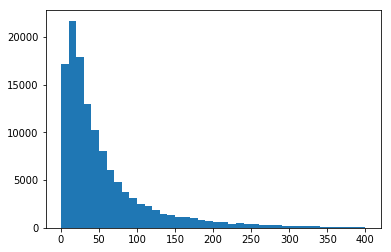

In [19]:
plt.hist(totalNumWords,bins = np.arange(0,410,10))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show()

First of all, input function is used to create and define a standalone Input layer that specifies the shape of input data. The input layer takes a shape argument that is a tuple that indicates the dimensionality of the input data. When input data is one-dimensional, the shape must explicitly leave room for the shape of the  mini-batch size used when splitting the data when training the network.  Therefore, the shape tuple is always defined with a hanging last dimension when the input is one-dimensional

## LSTM Model construction

In [20]:
inp = Input(shape=(maxlen, ))
inp

<tf.Tensor 'input_1:0' shape=(?, 200) dtype=float32>

Output from the Input() is passed on to the embedding layer where the words are defined in a vector space depending on the surrounding words, the output of the embedding layer is a list of co-ordinates of the words in the vector space. Basically it's a mapping of the original input data into some set of real-valued dimensions,  and the "position" of the original input data in those dimensions is organized to improve the task. So, similar words might be put on the same dimensiona nd hence the overall dimensions are reduced drastically. Distance between words are used to determine the relevance of concepts.

In [21]:
embed_size = 128
x = Embedding(max_features, embed_size)(inp)

In LSTM, we feed the output of one layer as an input to the next layer. Final output is taken after some number of recursions. We want out LSTM to produce output with dimensions as 60. Taking input from the previous layers, LSTM runs 200 times, passing the coordinates of the words each time.

In [22]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)

The model x obtained after fillting LSTM will be a 3D model, we need to convert the same into a 2D one, hence we use GlobalMaxPool()

In [23]:
x = GlobalMaxPool1D()(x)

In order to get e generalization of the data, we remove some part of the data so that the next layer handles missing data forcefully Dropout(0.1) disables 10% of the nodes

In [24]:
x = Dropout(0.1)(x)

The output of Dropout is given as input to a "Relu" for reduced likelihood of vanishing gradient (avoid a neural to quicky die). Dimension of the output is set to 50 Again a Dropout of 10% is achieved and the output is now given to a sigmoid function. Sigmoid function produces output between 0 and 1, hence we achive a binary classification for each of the 6 labels;.

In [25]:
x = Dense(50, activation="relu")(x)

In [26]:
x = Dropout(0.1)(x)

In [27]:
x = Dense(6, activation="sigmoid")(x)

Using Adam optimization algorithm that can used instead of the classical stochastic gradient descent procedure to update network weights iterative based in training data using Root Mean Square Propagation and Adaptive Gradient Algorithm.

In [28]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', f1])

We'll feed in a list of 32 padded, indexed sentence for each batch and split 10% of the data as a validation set. This validation set will be used to assess whether the model has overfitted, for each batch.  The model will also run for 2 epochs which is enough regarding the algorthm and the amount of data. 

We catually should consider the total training size/batch size, that many number of batches pass through our algorithm  in each epoch. Typically, you'll split your test set into small batches for the network to learn from, and make the training go step by step through your number of layers, applying gradient-descent all the way down. All these small steps can be called iterations.

In [29]:
batch_size = 32
epochs = 2
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 114890 samples, validate on 12766 samples
Epoch 1/2
114890/114890 [==============================] - 1078s 9ms/step - loss: 0.0770 - acc: 0.9762 - f1: 0.4786 - val_loss: 0.0502 - val_acc: 0.9816 - val_f1: 0.6600
Epoch 2/2
114890/114890 [==============================] - 1121s 10ms/step - loss: 0.0461 - acc: 0.9829 - f1: 0.6679 - val_loss: 0.0477 - val_acc: 0.9816 - val_f1: 0.6682


### The training model perform over 0.983 in accuracy but has a F1 of 0.67 due to the fact that some labels have a small number of observation. For instance threat label has 31 observations which is really small compare to the 159571 total observation. It will be interesting to add more observations relative to this label to have good recall for our model. At the end, we can see that the model is really good for classifying non toxic comments over the internet.